# Выпускной проект.

###  Описание проекта

Проект:
 - Заказчик - металлургический комбинат.
 
Цель:
 - Цель заказчика - уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.
 - Задача проекта -  построить модель, которая будет предсказывать температуру сплава. Разработанная модель будет использована для имитации технологического процесса. Модель позволит снизить затраты на электричество, обслуживание и ремонт.

Данные представлены 7-мью файлами:
 - data_arc_new.csv — данные об электродах; 
 - data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
 - data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
 - data_gas_new.csv — данные о продувке сплава газом;
 - data_temp_new.csv — результаты измерения температуры;
 - data_wire_new.csv — данные о проволочных материалах (объём);
 - data_wire_time_new.csv — данные о проволочных материалах (время).
 
Дополнительная информация:
 - Целевой признак - последнее измерение температуры партии.
 - В одной партии несколько итераций нагрева (полных циклов).
 - Целевая метрика MAE (MAE<=6.8)
 - random_state  = 91224;

Дополнения заказчика:
 - Информация по выбросам (отрицательная реактивная мощность, температура плавления стали менее 1500)
 - посчитать и проинтерпретировать R2 для лучшей модели на тестовой выборке
 - провести анализ важности признаков лучшей модели

### Загрузка данных

In [1]:
!pip install phik shap matplotlib seaborn --upgrade 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
from phik.report import plot_correlation_matrix
from phik import report
import shap
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [3]:
data_arc_new=pd.read_csv('', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])

In [4]:
data_bulk_new=pd.read_csv('')

In [5]:
data_bulk_time_new=pd.read_csv('')

In [6]:
data_gas_new=pd.read_csv('')

In [7]:
data_temp_new=pd.read_csv('', parse_dates=['Время замера'])

In [8]:
data_wire_new=pd.read_csv('')

In [9]:
data_wire_time_new=pd.read_csv('', parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'])

### Исследовательский анализ каждого документа

Выполнен исследовательский анализ каждого документа и сделаны выводы об имеющихся признаках.

##### Иследование документа data_arc_new

In [10]:
# Данные об электродах
data_arc_new.info()
display(data_arc_new.describe())
display(data_arc_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [11]:
# Выделена аномалия, про которую говорил заказчик. Она единичная.
data_arc_new[data_arc_new['Реактивная мощность']<=0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


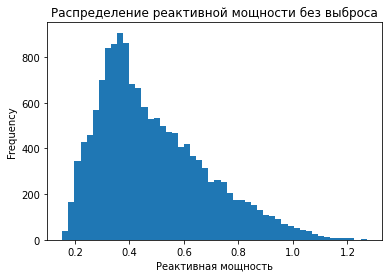

In [12]:
# Как будет выглядеть распределение данных без аномалии, которую уберу в главе предобработки данных.
gr1=data_arc_new[data_arc_new['Реактивная мощность']>=0]['Реактивная мощность'].plot(kind='hist', bins=50, title='Распределение реактивной мощности без выброса')
gr1.set_xlabel('Реактивная мощность');

Итоги по data_arc_new:
- Пропусков нет.
- Начало нагрева дугой и Конец нагрева дугой загружены в формате datetime64. 
- Реактивная мощность - единичный производственный выброс.
<br/><br/>
- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

##### Иследование документа data_bulk_new

In [13]:
# Данные о подаче сыпучих материалов (объём)
data_bulk_new.info()
display(data_bulk_new.describe())
display(data_bulk_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [14]:
# Много пропусков, они будут заполнены позже.
# Анализ самых заполненных признаков
(3129-(data_bulk_new.isna().sum())).sort_values(ascending=False)

key        3129
Bulk 14    2806
Bulk 12    2450
Bulk 15    2248
Bulk 3     1298
Bulk 4     1014
Bulk 6      576
Bulk 1      252
Bulk 11     177
Bulk 10     176
Bulk 5       77
Bulk 7       25
Bulk 2       22
Bulk 9       19
Bulk 13      18
Bulk 8        1
dtype: int64

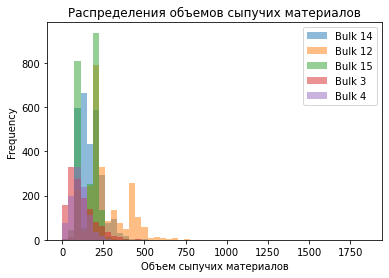

In [15]:
# Распределения объемов сыпучих материалов, которые чаще всего подавались НА ОДНОМ ГРАФИКЕ
list_bulk=['Bulk 14', 'Bulk 12', 'Bulk 15', 'Bulk 3', 'Bulk 4']
gr2=data_bulk_new[list_bulk].plot(kind='hist', bins=50, alpha=0.5, title='Распределения объемов сыпучих материалов')
gr2.set_xlabel('Объем сыпучих материалов');

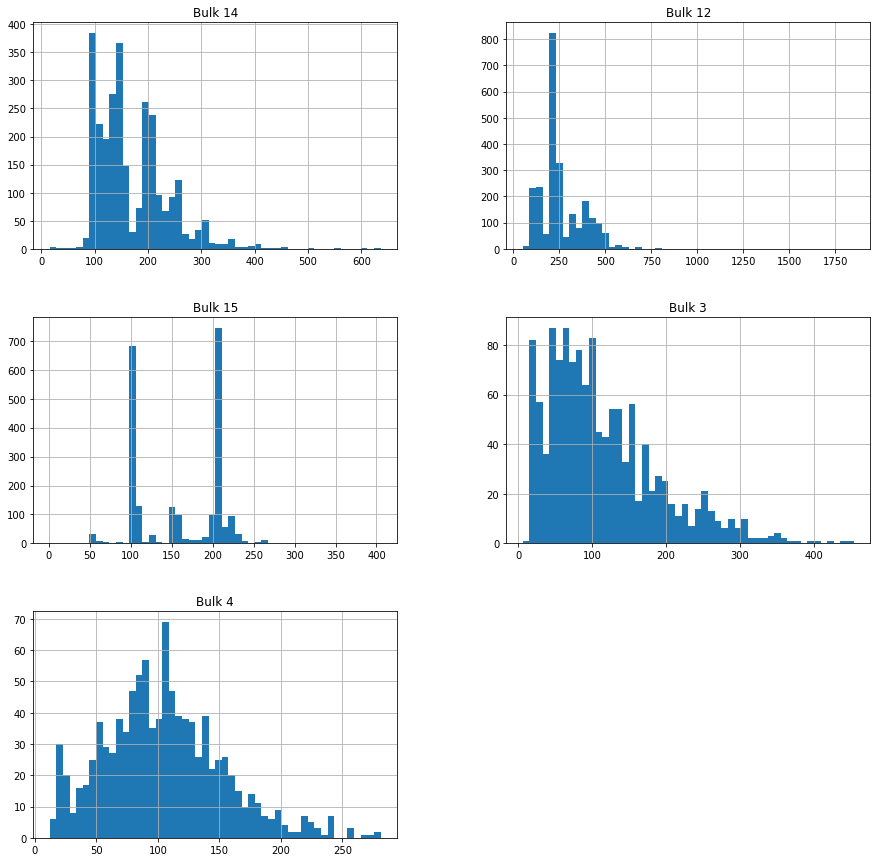

In [16]:
# Распределения объемов сыпучих материалов, которые чаще всего подавались НА РАЗНЫХ ГРАФИКАХ
data_bulk_new[list_bulk].hist(bins=50, figsize=(15, 15));

Итоги по data_bulk_new:
- Много пропусков для разных материалов.
- Пропуски будут заполнены нулевыми значениями, тк предполагается, что материал просто не подавался в ковш.
- Признаки 14, 12, 15, 3, 4 заполнены лучше прочих. Их распределения в целом находятся в одном диапазоне. Явных выбросов не наблюдается, распределения смещены в сторону меньших значений и представлены лог-нормальными распределениями. У признака Bulk12 имеются два локальных максимума.
<br/><br/>
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

##### Иследование документа data_bulk_time_new.csv

In [17]:
# Данные о подаче сыпучих материалов (время)
data_bulk_time_new.info()
display(data_bulk_time_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [18]:
# Анализ самых заполненных признаков
# Такое же заполнение как и у data_bulk_new
(3129-(data_bulk_time_new.isna().sum())).sort_values(ascending=False)

key        3129
Bulk 14    2806
Bulk 12    2450
Bulk 15    2248
Bulk 3     1298
Bulk 4     1014
Bulk 6      576
Bulk 1      252
Bulk 11     177
Bulk 10     176
Bulk 5       77
Bulk 7       25
Bulk 2       22
Bulk 9       19
Bulk 13      18
Bulk 8        1
dtype: int64

Итоги по data_bulk_time_new:

- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.
<br/><br/>
- Документ о времени подачи материалов не войдет в финальную таблицу,нужен для проверки корректности данных.
- Данные лучше всего заполнены для тех же признаков: Bulk 14, Bulk 12, Bulk 15, Bulk 3, Bulk 4

#####  Иследование документа data_gas_new.csv

In [19]:
# Данные о продувке сплава газом
data_gas_new.info()
display(data_gas_new.describe())
display(data_gas_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


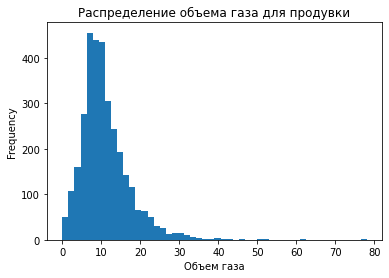

In [20]:
gr3=data_gas_new['Газ 1'].plot(kind='hist', bins=50, title='Распределение объема газа для продувки')
gr3.set_xlabel('Объем газа');

 Итоги по data_gas_new:
 - key — номер партии;
 - Газ 1 — объём подаваемого газа,
 - Явных выбросов не наблюдается, распределение смещено в сторону меньших значений и представлено лог-нормальным распределением.

##### Иследование документа data_temp_new.csv

In [21]:
# Результаты измерения температуры;
data_temp_new.info()
display(data_temp_new.describe())
display(data_temp_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


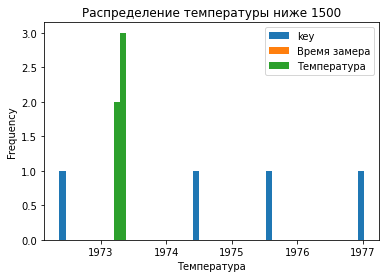

In [22]:
gr4=data_temp_new[data_temp_new['Температура']<=1500].plot(kind='hist', bins=50, title='Распределение температуры ниже 1500')
gr4.set_xlabel('Температура');

In [23]:
# Присутствуют 5 производственных выбросов (связанных с температурой, которая меньше температуры плавления стали), они будут удалены в предобработке данных
data_temp_new[data_temp_new['Температура']<=1500]['Температура'].count()

5

 Итоги по data_temp_new:
- Время замера в правильном формате
- В признаке температура есть пропуски
- В признаке температура есть 5 производственых выбросов
<br/><br/>
- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.


##### Иследование документа data_wire_new.csv

In [24]:
# Данные о проволочных материалах (объём);
data_wire_new.info()
display(data_wire_new.describe())
display(data_wire_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Заполненность
# Wire 1, Wire 2 хорошо заполнены
(len(data_wire_new.key)-data_wire_new.isna().sum()).sort_values(ascending=False)

key       3081
Wire 1    3055
Wire 2    1079
Wire 6      73
Wire 3      63
Wire 9      29
Wire 8      19
Wire 4      14
Wire 7      11
Wire 5       1
dtype: int64

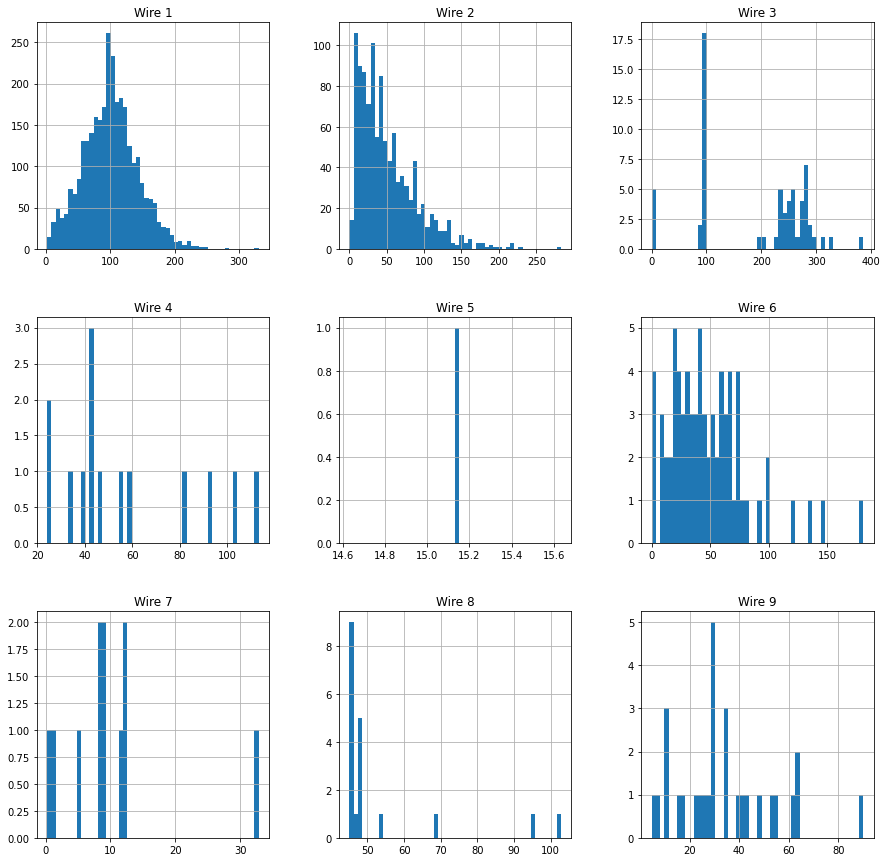

In [26]:
# Распределение объемов
data_wire_new.drop(['key'], axis=1).hist(bins=50, figsize=(15, 15));

  Итоги по data_wire_new:
 - key — номер партии;
 - Wire 1 … Wire 9 — объём подаваемых проволочных материалов.
 - Много пропусков в многих признаках (материал не подавался в ковш)
 - Хорошая заполненность у признаков Wire 1 и Wire 2. 
 - Там, где подавалось много материала - нормальное распределение, где не так много лог-нормальное, смещенное к меньшим значениям.

##### Иследование документа data_wire_time_new.csv

In [27]:
# Данные о проволочных материалах (время)
data_wire_time_new.info()
display(data_wire_time_new.describe())
display( data_wire_time_new.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 15:01:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT


 Итоги по data_wire_time_new:
- Wire 1 … Wire 9 загружены в формате datetime64
- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

### Предобработка данных

#### Удаление производственных аномалий

Условия:
 - Удаление ключа с отрицательной реактивной мощностью.
 - Удаление ключа с температурами <1500 (температура плавления стали)
 - Это выбросы производства
 - Прочие выбросы удаляются только в обучающей выборке (чтобы искуственно не улучшить показания тестовой выборки)

In [28]:
# Удаление ключа с отрицательной реактивной мощностью - сделано
data_arc_new=data_arc_new[data_arc_new['Реактивная мощность']>=0]
data_arc_new[data_arc_new['Реактивная мощность']<=0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


In [29]:
# Удаление ключа с температурами <1500 (температура плавления стали) - сделано
data_temp_new=data_temp_new[data_temp_new['Температура']>=1500]
data_temp_new[data_temp_new['Температура']<=1500]

,key,Время замера,Температура


#### Удаление ключей с одним замером температуры

Условия:
 - Удалить ключи с одним замером температуры, они не подходят для моделирования (нужны начальное и конечное значения)

In [30]:
key_counts = data_temp_new['key'].value_counts()
key_counts

2108    17
1513    16
1689    16
46      14
322     14
        ..
3236     1
2963     1
2955     1
2947     1
2525     1
Name: key, Length: 3215, dtype: int64

In [31]:
valid_keys = key_counts[key_counts > 1].index
valid_keys

Int64Index([2108, 1513, 1689,   46,  322,   44, 1829,  638, 1958, 1880,
            ...
             661,  977, 1369,  112, 1281, 2194, 1449,  530, 2112,  269],
           dtype='int64', length=2475)

In [32]:
data_temp_new = data_temp_new[data_temp_new['key'].isin(valid_keys)]
(data_temp_new['key'].value_counts()==1).sum()

0

#### Удаление промежуточных температур в партии, создание признака Количество итераций

Условия:
 - Исследовать можно только первую температуру в партии (замеренную до начала исследований).
 - Промежуточные значения должны быть удалены, так как могут привести к утечке данных.
 - Дополнительно на этом этапе создан признак Количество итераций

In [33]:
data_temp_new.head(15)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [34]:
# Создание временного признака - Количество итераций
data_add=data_temp_new.groupby('key').count()['Время замера']
data_add

key
1       6
2       5
3       6
4       5
5       5
       ..
2495    5
2496    7
2497    4
2498    6
2499    5
Name: Время замера, Length: 2475, dtype: int64

In [35]:
# Запись признака в датафрейм
data_temp_new['Количество итераций'] = data_temp_new.key.map(data_add)
data_temp_new.head()

,key,Время замера,Температура,Количество итераций
0,1,2019-05-03 11:02:04,1571.0,6
1,1,2019-05-03 11:07:18,1604.0,6
2,1,2019-05-03 11:11:34,1618.0,6
3,1,2019-05-03 11:18:04,1601.0,6
4,1,2019-05-03 11:25:59,1606.0,6


In [36]:
data_temp_new=data_temp_new.groupby("key").apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)
data_temp_new.head(6)

,key,Время замера,Температура,Количество итераций
0,1,2019-05-03 11:02:04,1571.0,6
1,1,2019-05-03 11:30:38,1613.0,6
2,2,2019-05-03 11:34:04,1581.0,5
3,2,2019-05-03 11:55:09,1602.0,5
4,3,2019-05-03 12:06:44,1596.0,6
5,3,2019-05-03 12:35:57,1599.0,6


#### Работа с пропусками для подаваемых материалов

Условия:
 - Если в данных о добавленных материалах пропуски, то материал не подавался в этой итерации в ковш и надо заполнить пропуски нулями.
 - Таблицы о времени подачи материалов в итоговую таблицу не войдут. Эти таблицы нужны для проверки корректности данных.

In [37]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [38]:
s = (len(data_bulk_new['key'])-(data_bulk_new.isna().sum())).sort_values(ascending=False)>=(len(data_bulk_new['key']))*0.8

In [39]:
s.index[s]

Index(['key', 'Bulk 14'], dtype='object')

In [40]:
data_bulk_new=data_bulk_new[s.index[s].to_list()]
data_bulk_new.head()

,key,Bulk 14
0,1,150.0
1,2,149.0
2,3,152.0
3,4,153.0
4,5,151.0


In [41]:
data_bulk_new['Bulk 14'].isna().sum()

323

In [42]:
data_bulk_new['Bulk 14']=data_bulk_new['Bulk 14'].fillna(0)
data_bulk_new['Bulk 14'].isna().sum()

0

In [43]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
s1 = (len(data_wire_new['key'])-(data_wire_new.isna().sum())).sort_values(ascending=False)>=(len(data_wire_new['key']))*0.8
s1

key        True
Wire 1     True
Wire 2    False
Wire 6    False
Wire 3    False
Wire 9    False
Wire 8    False
Wire 4    False
Wire 7    False
Wire 5    False
dtype: bool

In [45]:
s1.index[s1]

Index(['key', 'Wire 1'], dtype='object')

In [46]:
data_wire_new=data_wire_new[s1.index[s1].to_list()]
data_wire_new.head()

,key,Wire 1
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,89.238236


In [47]:
data_wire_new['Wire 1']=data_wire_new['Wire 1'].fillna(0)
data_wire_new['Wire 1'].isna().sum()

0

#### Агрегация параметров

Условия:
 - Объект моделирования - партия целиком, поэтому данные будут агрегированы по партиям. Будет посчитана сумма 

In [48]:
data_arc_new.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [49]:
# Агрегация данных
agg_data = data_arc_new.groupby("key").agg({
    "Активная мощность": "sum",
    "Реактивная мощность": "sum"
}).reset_index()


In [50]:
# Переименование колонки для нового признака
agg_data.rename(columns={
    "Активная мощность": "Суммарная активная мощность",
    "Реактивная мощность": "Суммарная реактивная мощность"
}, inplace=True)

In [51]:
# Объединение агрегированных данных с исходным DataFrame
data_arc_new = data_arc_new.merge(agg_data, on="key", how="left")
data_arc_new.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Суммарная активная мощность,Суммарная реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3.036730,2.142821
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3.036730,2.142821
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,3.036730,2.142821
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,3.036730,2.142821
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,3.036730,2.142821
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,2.139408,1.453357
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,2.139408,1.453357
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,2.139408,1.453357
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,2.139408,1.453357
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,4.063641,2.937457


### Добавление признаков

#### Физические величины

Условия:
 - Полная мощность - Сумма квадратов активной и реактивной мощностей под корнем
 - Работа - произведение полной мощности и времени нагрева
 - Число итераций (по плану, составленному до начала исследований, это не утечка данных)

In [52]:
#  Добавление полной мощности
data_arc_new['Полная мощность']=(data_arc_new['Активная мощность']**2+data_arc_new['Реактивная мощность']**2)**0.5
# Добавление суммарной полной мощности
data_arc_new['Суммарная полная мощность']=(data_arc_new['Суммарная активная мощность']**2+data_arc_new['Суммарная реактивная мощность']**2)**0.5
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Суммарная активная мощность,Суммарная реактивная мощность,Полная мощность,Суммарная полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3.03673,2.142821,0.371123,3.71664
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3.03673,2.142821,0.902319,3.71664
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,3.03673,2.142821,0.722536,3.71664
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,3.03673,2.142821,0.642824,3.71664
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,3.03673,2.142821,1.079934,3.71664


In [53]:
# Добавление параметра - Время нагрева дугой
data_arc_new['Время нагрева дугой']=data_arc_new['Конец нагрева дугой']-data_arc_new['Начало нагрева дугой']

In [54]:
agg_data2=data_arc_new.groupby('key').agg({'Время нагрева дугой':'sum'}).reset_index()
agg_data2.columns = ['key', 'Суммарное время нагрева дугой']

In [55]:
data_arc_new = data_arc_new.merge(agg_data2, on="key", how="left")
data_arc_new.head(20)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Суммарная активная мощность,Суммарная реактивная мощность,Полная мощность,Суммарная полная мощность,Время нагрева дугой,Суммарное время нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3.036730,2.142821,0.371123,3.716640,0 days 00:03:48,0 days 00:18:18
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3.036730,2.142821,0.902319,3.716640,0 days 00:03:05,0 days 00:18:18
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,3.036730,2.142821,0.722536,3.716640,0 days 00:02:52,0 days 00:18:18
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,3.036730,2.142821,0.642824,3.716640,0 days 00:06:05,0 days 00:18:18
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,3.036730,2.142821,1.079934,3.716640,0 days 00:02:28,0 days 00:18:18
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,2.139408,1.453357,0.440239,2.586371,0 days 00:02:17,0 days 00:13:31
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,2.139408,1.453357,0.332731,2.586371,0 days 00:05:38,0 days 00:13:31
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,2.139408,1.453357,0.860064,2.586371,0 days 00:02:06,0 days 00:13:31
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,2.139408,1.453357,0.955315,2.586371,0 days 00:03:30,0 days 00:13:31
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,4.063641,2.937457,1.373863,5.014163,0 days 00:04:40,0 days 00:10:55


In [56]:
data_arc_new['Суммарное время нагрева дугой sec'] = data_arc_new['Суммарное время нагрева дугой'].dt.seconds

In [57]:
# Добавление Работы
data_arc_new['Суммарная работа']=data_arc_new['Суммарная полная мощность']*data_arc_new['Суммарное время нагрева дугой sec']
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Суммарная активная мощность,Суммарная реактивная мощность,Полная мощность,Суммарная полная мощность,Время нагрева дугой,Суммарное время нагрева дугой,Суммарное время нагрева дугой sec,Суммарная работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3.03673,2.142821,0.371123,3.71664,0 days 00:03:48,0 days 00:18:18,1098,4080.870431
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3.03673,2.142821,0.902319,3.71664,0 days 00:03:05,0 days 00:18:18,1098,4080.870431
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,3.03673,2.142821,0.722536,3.71664,0 days 00:02:52,0 days 00:18:18,1098,4080.870431
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,3.03673,2.142821,0.642824,3.71664,0 days 00:06:05,0 days 00:18:18,1098,4080.870431
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,3.03673,2.142821,1.079934,3.71664,0 days 00:02:28,0 days 00:18:18,1098,4080.870431


#### Признаки на основе времени

Условия:
 - Время нагрева дугой - уже посчитан
 - Время замера между первой и последней температурами
 - Количество итераций

In [58]:
# Время замера между первой и последней температурами
data_temp_new['Временной интервал'] = data_temp_new.groupby('key')['Время замера'].transform(lambda x: x.iloc[1] - x.iloc[0])
data_temp_new['Временной интервал сек']=data_temp_new['Временной интервал'].dt.seconds
data_temp_new.head()

,key,Время замера,Температура,Количество итераций,Временной интервал,Временной интервал сек
0,1,2019-05-03 11:02:04,1571.0,6,0 days 00:28:34,1714
1,1,2019-05-03 11:30:38,1613.0,6,0 days 00:28:34,1714
2,2,2019-05-03 11:34:04,1581.0,5,0 days 00:21:05,1265
3,2,2019-05-03 11:55:09,1602.0,5,0 days 00:21:05,1265
4,3,2019-05-03 12:06:44,1596.0,6,0 days 00:29:13,1753


### Объединение данных

Условия:
 - Объединение таблиц по INNER (берем те партии, которые представлены во всех таблицах)
 - Должно быть не более 2332 ключей
 - Не должно быть ключей с номерами более 2500 (.tail() будет выведен для проверки)

In [59]:
# Доподготовка таблиц для объединения
data_arc_new.set_index('key', inplace=True)
data_bulk_new.set_index('key', inplace=True)
data_gas_new.set_index('key', inplace=True)
data_temp_new.set_index('key', inplace=True)
data_wire_new.set_index('key', inplace=True)

In [60]:
data_arc_new=data_arc_new.drop(columns=['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность', 'Полная мощность', 'Время нагрева дугой'])
data_arc_new.head()

,Суммарная активная мощность,Суммарная реактивная мощность,Суммарная полная мощность,Суммарное время нагрева дугой,Суммарное время нагрева дугой sec,Суммарная работа
key,,,,,,
1,3.03673,2.142821,3.71664,0 days 00:18:18,1098,4080.870431
1,3.03673,2.142821,3.71664,0 days 00:18:18,1098,4080.870431
1,3.03673,2.142821,3.71664,0 days 00:18:18,1098,4080.870431
1,3.03673,2.142821,3.71664,0 days 00:18:18,1098,4080.870431
1,3.03673,2.142821,3.71664,0 days 00:18:18,1098,4080.870431


In [61]:
data_arc_new=data_arc_new.groupby('key').agg('mean')
data_arc_new.head()

,Суммарная активная мощность,Суммарная реактивная мощность,Суммарная полная мощность,Суммарное время нагрева дугой sec,Суммарная работа
key,,,,,
1,3.036730,2.142821,3.716640,1098,4080.870431
2,2.139408,1.453357,2.586371,811,2097.546600
3,4.063641,2.937457,5.014163,655,3284.276844
4,2.706489,2.056992,3.399456,741,2518.996645
5,2.252950,1.687991,2.815155,869,2446.369640


In [62]:
# Объединение таблиц
final_table=data_temp_new.join([data_bulk_new, data_gas_new, data_arc_new, data_wire_new], 
                              how='inner')

In [63]:
final_table=final_table.reset_index()
final_table.head()

,key,Время замера,Температура,Количество итераций,Временной интервал,Временной интервал сек,Bulk 14,Газ 1,Суммарная активная мощность,Суммарная реактивная мощность,Суммарная полная мощность,Суммарное время нагрева дугой sec,Суммарная работа,Wire 1
0,1,2019-05-03 11:02:04,1571.0,6,0 days 00:28:34,1714,150.0,29.749986,3.036730,2.142821,3.716640,1098,4080.870431,60.059998
1,1,2019-05-03 11:30:38,1613.0,6,0 days 00:28:34,1714,150.0,29.749986,3.036730,2.142821,3.716640,1098,4080.870431,60.059998
2,2,2019-05-03 11:34:04,1581.0,5,0 days 00:21:05,1265,149.0,12.555561,2.139408,1.453357,2.586371,811,2097.546600,96.052315
3,2,2019-05-03 11:55:09,1602.0,5,0 days 00:21:05,1265,149.0,12.555561,2.139408,1.453357,2.586371,811,2097.546600,96.052315
4,3,2019-05-03 12:06:44,1596.0,6,0 days 00:29:13,1753,152.0,28.554793,4.063641,2.937457,5.014163,655,3284.276844,91.160157


In [64]:
final_table=pd.concat([
    final_table.groupby('key')['Время замера'].min(),
    final_table.groupby('key')['Время замера'].max(),
    final_table.groupby('key')['Температура'].first(),
    final_table.groupby('key')['Температура'].last(),
    final_table.groupby('key')[['Количество итераций', 'Временной интервал сек', 'Bulk 14', 'Wire 1', 'Газ 1', 'Суммарная активная мощность', 'Суммарная реактивная мощность', 'Суммарная полная мощность', 'Суммарное время нагрева дугой sec', 'Суммарная работа']].first()
], axis=1).reset_index()
final_table.columns=['key', 'Время замера начало', 'Время замера конец', 'Температура начало', 'Температура конец', 'Количество итераций', 'Временной интервал сек', 'Bulk 14', 'Wire 1', 'Газ 1', 'Суммарная активная мощность', 'Суммарная реактивная мощность', 'Суммарная полная мощность', 'Суммарное время нагрева дугой sec', 'Суммарная работа']

In [65]:
final_table.head()

,key,Время замера начало,Время замера конец,Температура начало,Температура конец,Количество итераций,Временной интервал сек,Bulk 14,Wire 1,Газ 1,Суммарная активная мощность,Суммарная реактивная мощность,Суммарная полная мощность,Суммарное время нагрева дугой sec,Суммарная работа
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6,1714,150.0,60.059998,29.749986,3.036730,2.142821,3.716640,1098,4080.870431
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5,1265,149.0,96.052315,12.555561,2.139408,1.453357,2.586371,811,2097.546600
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6,1753,152.0,91.160157,28.554793,4.063641,2.937457,5.014163,655,3284.276844
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5,1220,153.0,89.063515,18.841219,2.706489,2.056992,3.399456,741,2518.996645
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5,1536,151.0,89.238236,5.413692,2.252950,1.687991,2.815155,869,2446.369640


In [66]:
if final_table['key'].value_counts().sum()<2332:
    print('Должно быть не более 2332 ключей - условие выполнено')
else:
    print('Должно быть не более 2332 ключей - условие НЕ выполнено')

Должно быть не более 2332 ключей - условие выполнено


In [67]:
# Не должно быть ключей с номерами более 2500
final_table['key'].tail(10)

2319    2489
2320    2490
2321    2492
2322    2493
2323    2494
2324    2495
2325    2496
2326    2497
2327    2498
2328    2499
Name: key, dtype: int64

### Исследовательский анализ объединенных данных

Условия:
 - Удаление ключа
 - Графики для всех признаков (гистограммы, бокс-плоты)

In [68]:
# Удаление ключа
final_table=final_table.drop('key', axis=1)

In [69]:
final_table.head()

,Время замера начало,Время замера конец,Температура начало,Температура конец,Количество итераций,Временной интервал сек,Bulk 14,Wire 1,Газ 1,Суммарная активная мощность,Суммарная реактивная мощность,Суммарная полная мощность,Суммарное время нагрева дугой sec,Суммарная работа
0,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6,1714,150.0,60.059998,29.749986,3.036730,2.142821,3.716640,1098,4080.870431
1,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5,1265,149.0,96.052315,12.555561,2.139408,1.453357,2.586371,811,2097.546600
2,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6,1753,152.0,91.160157,28.554793,4.063641,2.937457,5.014163,655,3284.276844
3,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5,1220,153.0,89.063515,18.841219,2.706489,2.056992,3.399456,741,2518.996645
4,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5,1536,151.0,89.238236,5.413692,2.252950,1.687991,2.815155,869,2446.369640


In [70]:
final_table_for_analysis=final_table.drop(columns=['Время замера начало','Время замера конец'])
final_table_for_analysis.head()

,Температура начало,Температура конец,Количество итераций,Временной интервал сек,Bulk 14,Wire 1,Газ 1,Суммарная активная мощность,Суммарная реактивная мощность,Суммарная полная мощность,Суммарное время нагрева дугой sec,Суммарная работа
0,1571.0,1613.0,6,1714,150.0,60.059998,29.749986,3.036730,2.142821,3.716640,1098,4080.870431
1,1581.0,1602.0,5,1265,149.0,96.052315,12.555561,2.139408,1.453357,2.586371,811,2097.546600
2,1596.0,1599.0,6,1753,152.0,91.160157,28.554793,4.063641,2.937457,5.014163,655,3284.276844
3,1601.0,1625.0,5,1220,153.0,89.063515,18.841219,2.706489,2.056992,3.399456,741,2518.996645
4,1576.0,1602.0,5,1536,151.0,89.238236,5.413692,2.252950,1.687991,2.815155,869,2446.369640


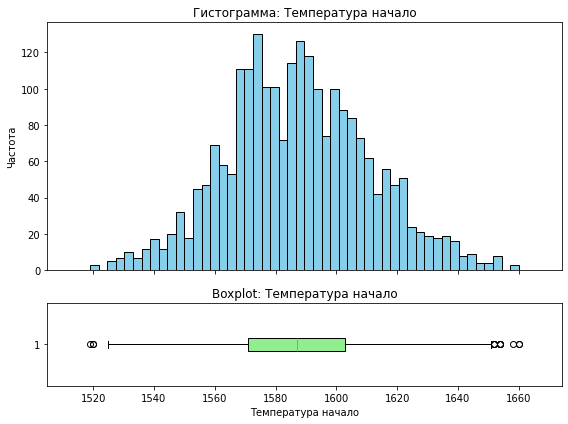

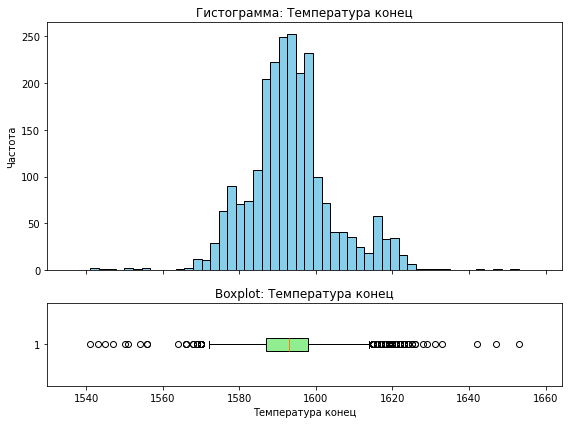

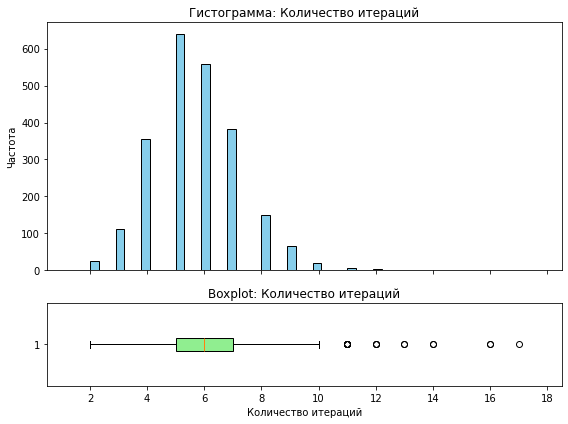

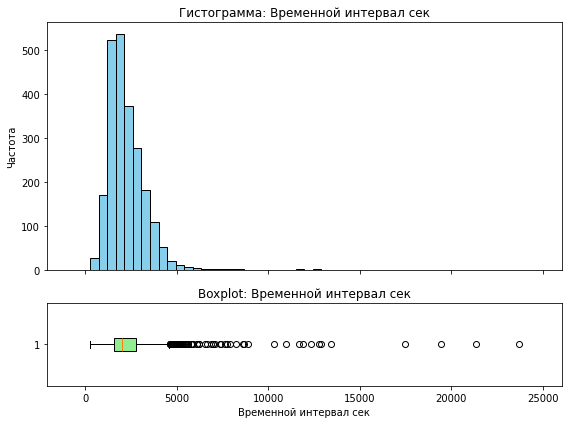

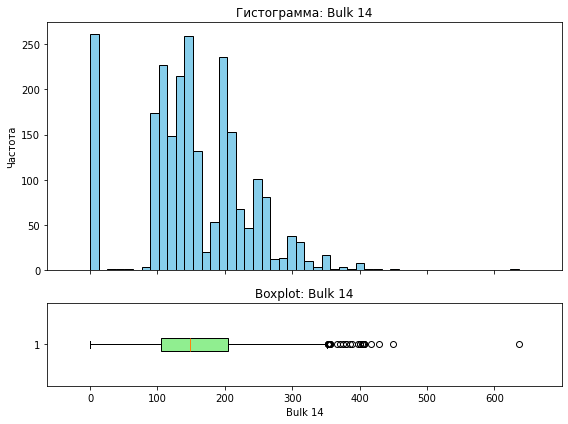

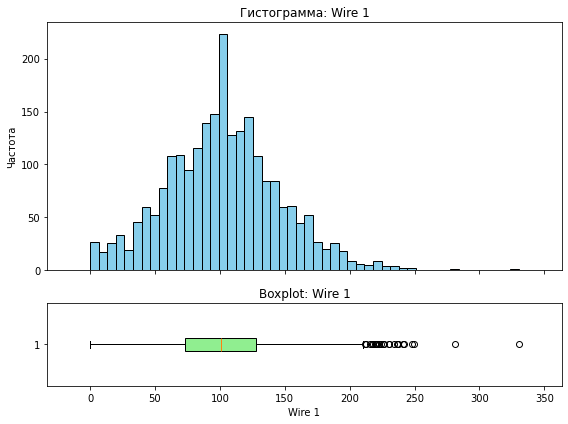

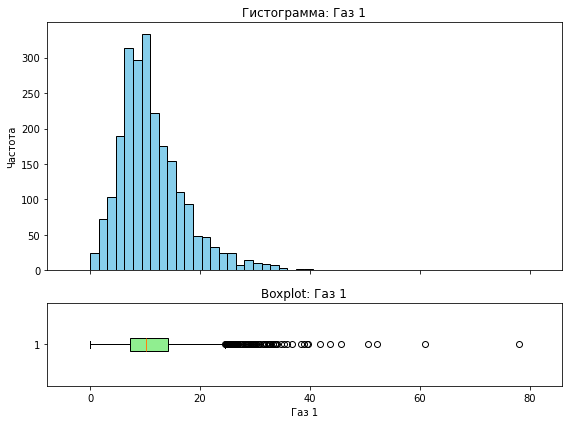

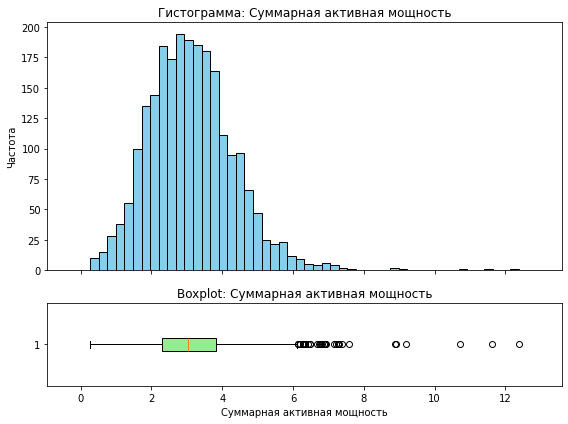

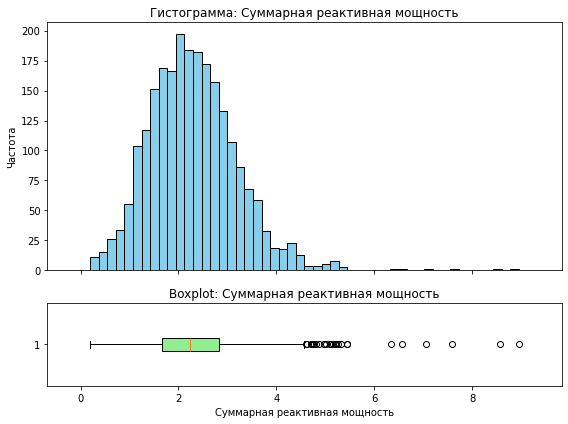

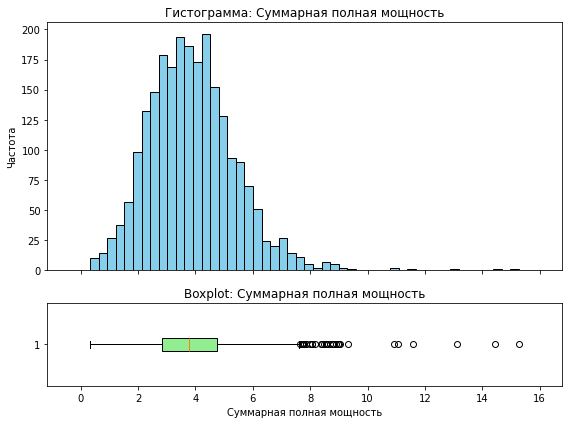

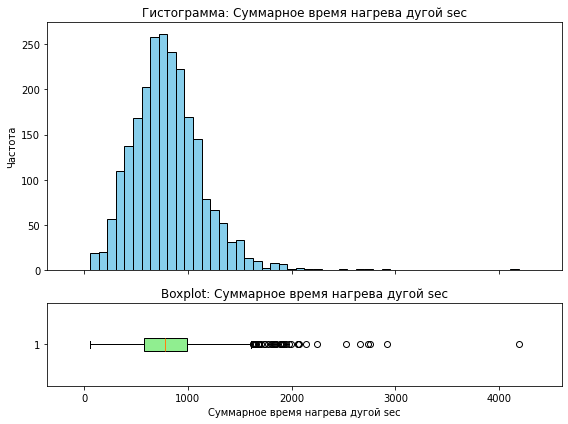

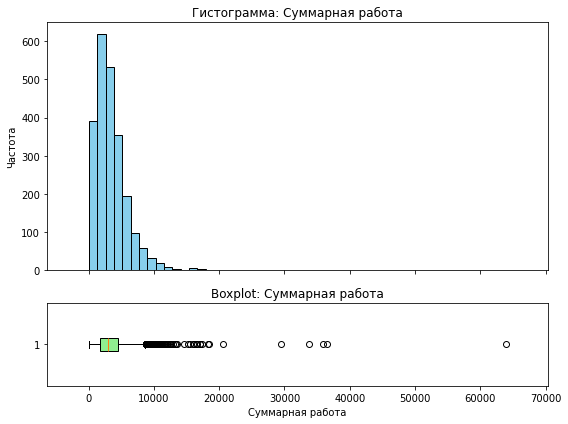

In [71]:
# Функция Построение гистограммы и boxplot для каждого числового признака

for column in final_table_for_analysis.columns:
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

        # Гистограмма
    axes[0].hist(final_table_for_analysis[column], bins=50, color='skyblue', edgecolor='black')
    axes[0].set_title(f'Гистограмма: {column}')
    axes[0].set_ylabel('Частота')

        # Boxplot
    axes[1].boxplot(final_table_for_analysis[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    axes[1].set_title(f'Boxplot: {column}')
    axes[1].set_xlabel(column)

        # Масштабирование оси X
    min_val = final_table_for_analysis[column].min()
    max_val = final_table_for_analysis[column].max()
    axes[0].set_xlim(min_val - (0.1 * abs(max_val - min_val)), max_val + (0.1 * abs(max_val - min_val)))
    axes[1].set_xlim(min_val - (0.1 * abs(max_val - min_val)), max_val + (0.1 * abs(max_val - min_val)))

        # Графики
    plt.tight_layout()
    plt.show()

In [72]:
final_table_for_analysis.describe()

,Температура начало,Температура конец,Количество итераций,Временной интервал сек,Bulk 14,Wire 1,Газ 1,Суммарная активная мощность,Суммарная реактивная мощность,Суммарная полная мощность,Суммарное время нагрева дугой sec,Суммарная работа
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1587.386003,1593.365393,5.693860,2321.810219,153.853585,102.443601,11.375600,3.125033,2.300522,3.881500,807.600687,3506.638477
std,23.619841,11.200915,1.607639,1385.191527,81.404354,43.539993,6.392041,1.221007,0.903968,1.516643,340.897332,3036.853297
min,1519.000000,1541.000000,2.000000,270.000000,0.000000,0.000000,0.008399,0.267676,0.196228,0.331897,57.000000,33.430208
25%,1571.000000,1587.000000,5.000000,1579.000000,105.000000,73.207679,7.282948,2.293900,1.669572,2.841624,581.000000,1708.483805
50%,1587.000000,1593.000000,6.000000,2045.000000,149.000000,101.119201,10.100950,3.035365,2.225398,3.767064,778.000000,2902.122400
75%,1603.000000,1598.000000,7.000000,2791.000000,204.000000,128.091599,14.216688,3.834300,2.829159,4.767256,993.000000,4511.394646
max,1660.000000,1653.000000,17.000000,23674.000000,636.000000,330.314424,77.995040,12.375636,8.949049,15.272257,4189.000000,63975.486018


Выводы по исследовательскому анализу финальных, собранных данных:
 - Признак Температура начало нормально распределен, нет явных выбросов или аномалий
 - Распределение признака Температура конец сужено, но в целом по форме это нормальное распределение. Присутствуют низкие и высокие значения в малом количестве, производственных выбросов нет.
 - Признак количество итераций - дискретный количественный признак. Без производственных аномалий.
 - Признак Временной интервал представлен лог-нормальным распределением, распределение смещено в сторону меньших значений
 - Признак Balk 14(подача сыпучего материала) представлен лог-нормальным распределением, распределение смещено в сторону меньших значений. Выделяются нулевые зеачения (в эти итерации не был подан материал)
 - Признак wire 1 представлен нормальным распределением, нет явных выбросов или аномалий
 - Признак Газ 1, представлен лог-нормальным распределением, распределение смещено в сторону меньших значений.
 - Признаки Суммарная активная мощность, Суммарная реактивная мощность, Суммарная полная мощность, Суммарное время нагрева дугой sec нормально распределены, нет явных выбросов или аномалий. Есть небольшое количество высоких значений во всех признаках
 - Суммарная работа предмтавлена лог-нормальным распределением.
 

### Корреляционный анализ данных

Условия:
 - Будет выведена матрица корреляции с heatmap
 - Будет проверка на мультиколлинеарность (>=0.9), так как будет использована линейная регрессия. В случае высокого коэффициента корреляции между признаками, один из признаков будет удален.

In [73]:
final_table_for_analysis.columns

Index(['Температура начало', 'Температура конец', 'Количество итераций',
       'Временной интервал сек', 'Bulk 14', 'Wire 1', 'Газ 1',
       'Суммарная активная мощность', 'Суммарная реактивная мощность',
       'Суммарная полная мощность', 'Суммарное время нагрева дугой sec',
       'Суммарная работа'],
      dtype='object')

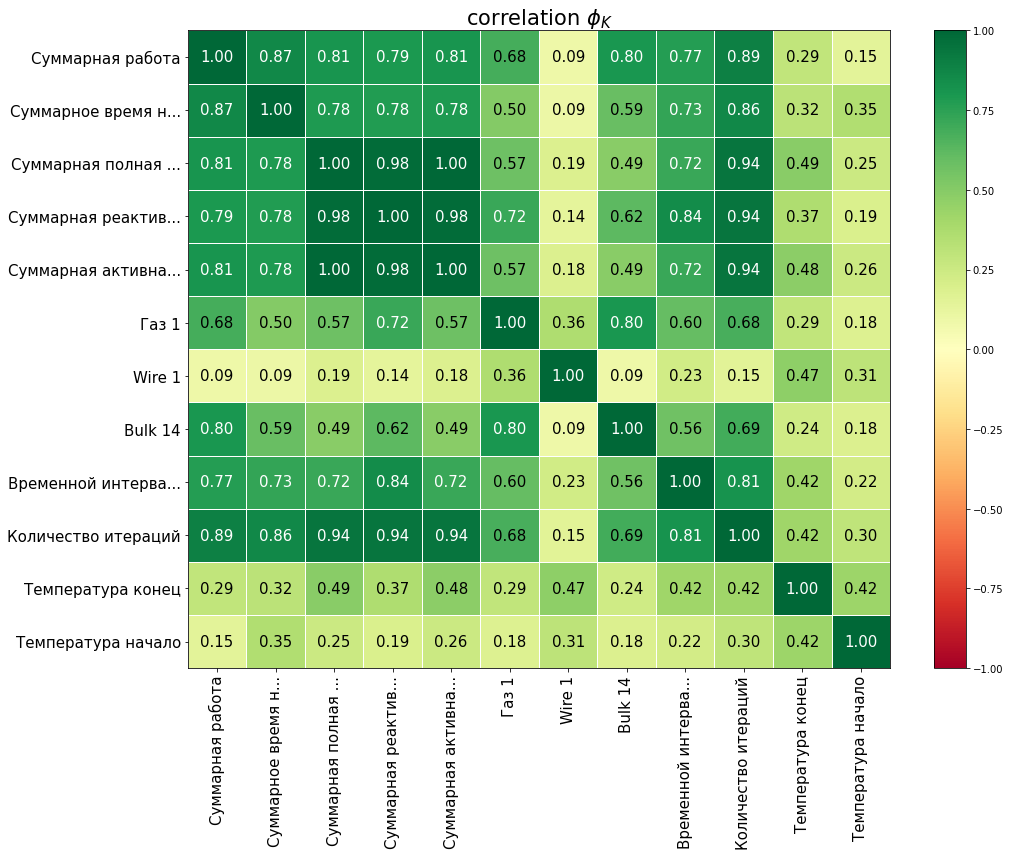

In [74]:
# phik correlation matrix для всех признаков, для линейных и нелинейных связей.


interval_cols=['Температура начало', 'Температура конец',
       'Временной интервал сек', 'Bulk 14', 'Wire 1', 'Газ 1',
       'Суммарная активная мощность', 'Суммарная реактивная мощность',
       'Суммарная полная мощность', 'Суммарное время нагрева дугой sec',
       'Суммарная работа']

# Вычисление коэффициентов корреляции phi для датафрейма df
phik_overview =final_table_for_analysis.phik_matrix(interval_cols)

# Визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

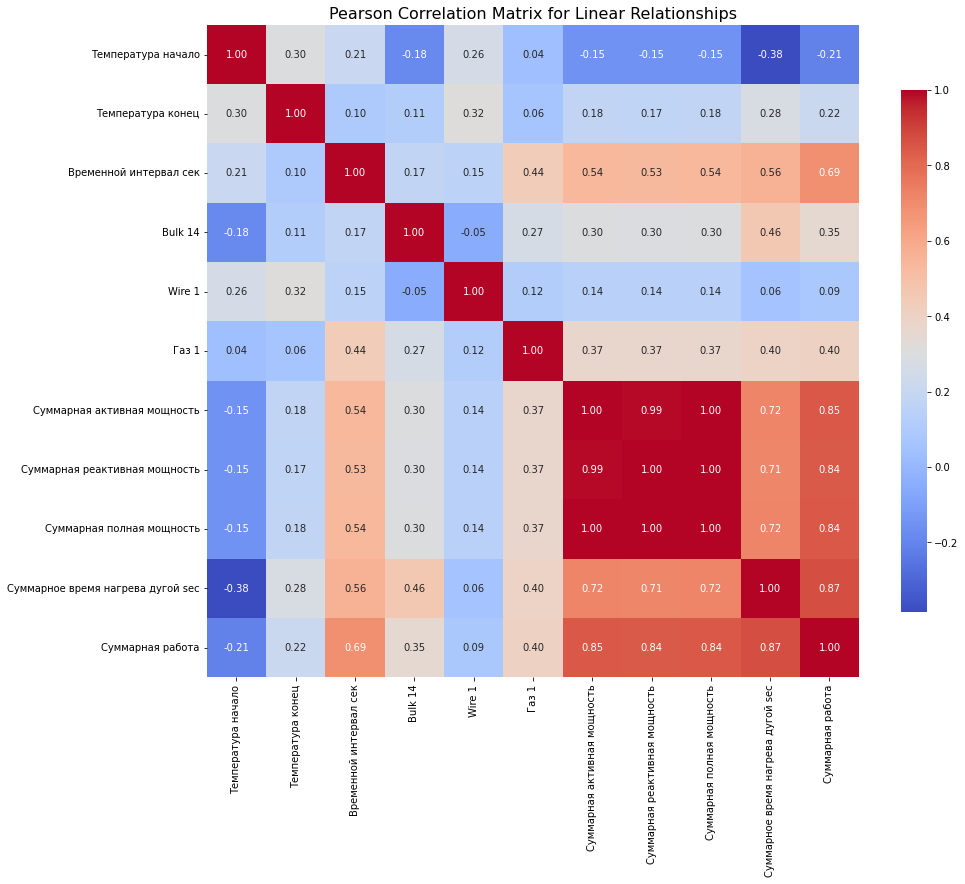

In [75]:
# Тепловая карта линейной корреляции по Пирсону
pearson_corr_matrix = final_table_for_analysis[interval_cols].corr(method='pearson')


plt.figure(figsize=(15, 12))
sns.heatmap(
    pearson_corr_matrix, 
    annot=True,   
    fmt=".2f",     
    cmap="coolwarm",  
    cbar_kws={'shrink': 0.8}, 
    square=True
)
plt.title("Pearson Correlation Matrix for Linear Relationships", fontsize=16)
plt.show()

Порверка на мультиколлинеарность по результатам Phi-корреляции:
 - Суммарная реактивная мощность и Суммарная полная мощность и Суммарная активная мощность и количество итераций имеют между собой корреляцию >0.9
   - Будет оставлен признак Суммарная полная мощность

In [76]:
df_ml=final_table_for_analysis.drop(columns=['Суммарная активная мощность', 'Суммарная реактивная мощность', 'Количество итераций'])

Итоги:
 - Сформирован датасет df_ml, который будет подан на обучение. Данные предобработаны, объединены, исследованы, убрана мультиколлениарность.

### Разбиение на выбрки

Условия:
 - 1700 и более строк в обучающей выборке 
 - пропорция 75%/25%
 - random_state = 91224
 

In [77]:
RANDOM_STATE=91224

In [78]:
X=df_ml.drop('Температура конец', axis=1)
y=df_ml['Температура конец']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

In [80]:
# 1700 и более строк в обучающей выборке
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1746, 8), (583, 8), (1746,), (583,))

In [81]:
# Список количественных признаков
num_columns = ['Температура начало', 'Временной интервал сек', 'Bulk 14', 'Wire 1',
       'Газ 1', 'Суммарная полная мощность',
       'Суммарное время нагрева дугой sec', 'Суммарная работа']

### Обучение и выбор лучшей модели

Условия:
 - Масштабирование будет выполнено в пайплайне
 - Обучение 2-x моделей и более
 - Использование Dummy Regressor в качестве базовой модели
 - Будут подобраны гиперпараметры (с перебором минимум двух параметров), за исключением модели линейной регрессии.
 - Для подбора лучшей модели используется randomized или gread search
 - Используется значение метрики на кросс-валидации, по метрике 'neg_mean_absolute_error', отображение через best_score_
 - Не использовать .predict

In [82]:
# Пайплайн для подготовки признаков из списка num_columns
# Масштабирование MinMaxScaler()
num_pipe = Pipeline(
    [
        (
            "simpleImputer_num",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "scaler",
            MinMaxScaler(),
        ),  
    ]
)

# Общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ("num", num_pipe, num_columns),
    ],
    remainder="passthrough",
)

# Итоговый пайплайн: подготовка данных и базовая модель - дерево решений
pipe_final = Pipeline(
    [
        ("preprocessor", data_preprocessor),
        ("models", DummyRegressor(strategy='mean')),
    ]
)

param_grid = [
    # Словарь для модели DecisionTreeClassifier()
    {
        "models": [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(10, 15),
        "models__max_features": range(2, 9),
        "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), "passthrough"],
    },
    # Линейная модель
    {
        "models": [LinearRegression()],
        "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), "passthrough"],
    },
]

In [83]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Выбор лучшей модели с использованием метрики SMAPE
GS = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',
    error_score='raise',
    n_jobs=-1,    
)
GS.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', GS.best_estimator_)
print ('Метрика по кросс-валидации:', abs(GS.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Температура начало',
                                                   'Временной интервал сек',
                                                   'Bulk 14', 'Wire 1', 'Газ 1',
                                                   'Суммарная полная мощность',
                                                   'Суммарное время нагрева '
                                                   'дугой sec',
   

Итоги:
 - Был использован пайплайн
 - Проверялись разные виды масштабирования данных
 - Обучались две модели: DecisionTreeClassifier(), LinearRegression()
 - Для модели  DecisionTreeClassifier() подбирались гиперпараметры "models__max_depth" и "models__max_features"
 - Использовался GridSearchCV, который рассмотрел все возможные варианты
 - Лучшая модель LinearRegression()
 - Метрика по кросс-валидации: 6.2414663010830775
 - Dummy regressor является базовой моделью в пайплайне. Возможно, этого Dummy теста достаточно. GridSearchCV не выбрал базовую модель, следовательно лучшая модель прошла проверку на адекватнось.

### Тестировапние лучшей модели

#### Тестирование лучшей модели

Условие:
 - Дополнительно посчитать и проинтерпретировать метрику R2 для модели.

In [84]:
model=GS.best_estimator_.named_steps['models']
model

LinearRegression()

In [85]:
preprocessor = GS.best_estimator_.named_steps['preprocessor']
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleImputer_num',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 ['Температура начало',
                                  'Временной интервал сек', 'Bulk 14', 'Wire 1',
                                  'Газ 1', 'Суммарная полная мощность',
                                  'Суммарное время нагрева дугой sec',
                                  'Суммарная работа'])])

In [86]:
X_train_ = preprocessor.fit_transform(X_train)
X_test_ = preprocessor.transform(X_test)

In [87]:
model.fit(X_train_, y_train)

LinearRegression()

In [88]:
preds = model.predict(X_test_)

In [89]:

print(f'Метрика R2 на тестовой выборке для лучшей модели: {r2_score(y_test, preds)}')
print(f'Метрика MAE на тестовой выборке для лучшей модели: {mean_absolute_error(y_test, preds)}')

Метрика R2 на тестовой выборке для лучшей модели: 0.465787773978964
Метрика MAE на тестовой выборке для лучшей модели: 6.2489267146799765


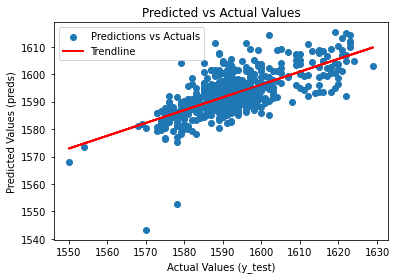

In [90]:
plt.scatter(y_test, preds, label="Predictions vs Actuals")

z = np.polyfit(y_test, preds, 1) 
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color="red", linewidth=2, label="Trendline")

plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (preds)")

plt.legend()

plt.show()

Интерпретация R2:  Помимо метрики MAE заказчик просил посчитать метрику R2. Хотя метрика имеет достаточно низкие значения (0.46), однако по графику видно, что причиной тому стали всего два выброса (плохо предсказанных значения). В целом, модель предсказала хорошо практически все значения.


#### Важность признаков

Условие:
 - проанализировать важность признаков, можно взять топ признаков.

In [91]:
X_train_ = pd.DataFrame(X_train_, columns=X_train.columns)
X_test_ = pd.DataFrame(X_test_, columns=X_test.columns)

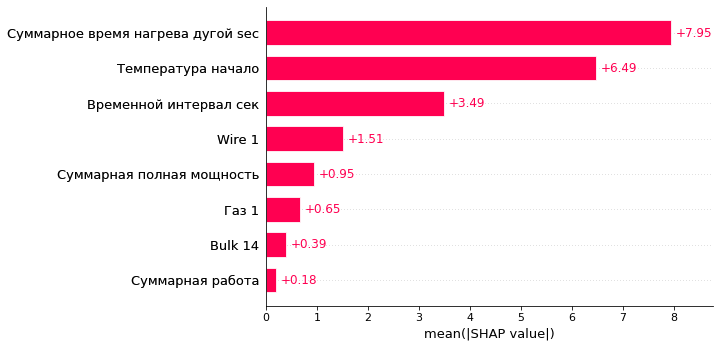

In [92]:
explainer = shap.LinearExplainer(model, X_test_)
shap_values = explainer(X_test_)
shap.plots.bar(shap_values, max_display=17) 

Итоги:
 - График общей значимости признаков для лучшей модели показывает, что тройка самых значимых признаков это:
    - Суммарное время нагрева дугой, Начальная температура и Время замера между первой и последней температурами в секундах.
 - Это коррелируется с данными тепловой карты, которая отражает линейную корреляцию между признаками (тройка лучших):
    - Wire 1, Начальная температура, Суммарное время нагрева дугой
 - Это коррелируется с данными тепловой карты, которая отражает НЕлинейную корреляцию между признаками (тройка лучших):
    - Полная мощность, Wire 1, Начальная температура, Время замера между первой и последней температурами в секундах
 - Как именно в производстве эти параметры влияют на целевой можно обсудить с инженерами.

### Итоговый вывод

В итоговом выводе описаны ключевые шаги с пояснениями; дано полное описание лучшей модели со значением метрики; указано, что цель достигнута. 

Проект состоит из 11 глав:
 - 1 Описание проекта - в главе описаны цели заказчика и проекта, имеющиеся данные, требования заказчика.
 - 2 Загрузка данных - загружены библиотеки, модули и данные
 - 3 Исследовательский анализ каждого документа - проведен анализ документов на наличие производственных аномалий, правильного типа данных, пропусков. Проведено ознакомление с каждым документом.
 - 4 Предобработка данных - в главе произведено удаление производственных аномалий (согласованных с заказчиком), удаление ключей с одним замером температуры (информация не пригодня для моделирования), удаление промежуточных температур в партии (чтобы избежать  утечки информации), работа с пропусками для подаваемых и насыпаемых материалов, агрегация параметров по партиям (партия - единица моделирования).
 - 5 Добавление признаков - были рассчитаны такие физические величины как полная мощность и работа, а также временные величины: время нагрева дуги, время между замерами начальной и конечной температур. Признак количество итераций был рассчитан в главе 4 (в подразделе Удаление промежуточных температур в партии, перед удалением промежуточных температур). Эти признаки не являются утечкой, так как определены планом, составленным до начала исследований.
 - 6 Далее были объединены данные по тому принципу, что оставлена только та информация, которая присутствует во всех документах.
 - 7 Проведен исследовательский анализ объединенных данных: построены гистограммы и бокс-плоты в едином масштабе, выведены статистические характеристики. Оценены распределения и возможные выбросы.
 - 8 Проведен корреляционный анализ данных (построены тепловые карты по линейной корреляции методом Пирсонa и нелинейной Phi-корреляции). Удалены один из признаков в мультиколлинеарных парах.
 - 9 Разбиение на выборки с соотношением 75/25, далее везде используется указанный заказчиком Random State
 - 10 Обучение и выбор лучшей модели происходит в пайплайне,проверялись разные виды масштабирования данных, обучались две модели: DecisionTreeClassifier(), LinearRegression(). Для модели DecisionTreeClassifier() подбирались гиперпараметры "models__max_depth" и "models__max_features". Использовался GridSearchCV, который рассмотрел все возможные варианты. Dummy regressor является базовой моделью в пайплайне. GridSearchCV не выбрал базовую модель, следовательно лучшая модель прошла проверку на адекватнось.
 - ПОЛНОЕ ОПИСАНИЕ ЛУЧШЕЙ МОДЕЛИ - Лучшая модель LinearRegression(), ее метрика по кросс-валидации: 6.2414663010830775. На тестовой выборке Метрика MAE чуть выше: 6.2489267146799765, а Метрика R2 на тестовой выборке для лучшей модели: 0.465787773978964. Согласно условию заказчика метрика MAE на тестовой выборке должна быть <=6.8, соответственно, цель достигнута, так как лучшая модель имеет метрику MAE 6.2. 
 - 11 Тестирование лучшей модели - в данной главе тестировалась лучшая модель на тестовой выборке. Помимо метрики MAE заказчик просил посчитать метрику R2. Хотя метрика имеет достаточно низкие значения (0.46), однако по графику видно, что причиной тому стали всего два выброса (плохо предсказанных значения). В целом, модель предсказала хорошо практически все значения. Так же в главе выполнен анализ важности признаков. Самые важные признаки: Суммарное время нагрева дугой, Начальная температура и Время замера между первой и последней температурами в секундах. Это согласуется с тепловыми картами корреляции и общей производственной логикой.
 
